In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from numpy import savetxt
from scipy import stats
from keras import Sequential
from keras.layers.core import Dense, Dropout
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

## **1. Prétraitement de données**

#### **1.1. Prétraitement de données d'apprentissage**

In [2]:
df_train = pd.read_csv("/kaggle/input/les-variables-des-images-de-publicit/data_train.csv", sep='\t') #dataframe object
print(df_train.shape)

(2459, 1559)


#### **1.1.1. Suppression des doublons**

In [3]:
# Sélectionnez des rangées en double, sauf la première occurrence, en fonction de toutes les colonnes :
df_duplicateRows = df_train[df_train.duplicated()]
print("Les rangées en double:", df_duplicateRows)
print(df_duplicateRows.shape[0]) # 562 rangées  / 2459 rangées 

# Suppression des rangées en double:
df_train = df_train.drop_duplicates() # 2459 - 562 = 1897 rangées 
print(df_train.shape) # (1897, 1559)

Les rangées en double:          X1     X2      X3   X4  X5  X6  X7  X8  X9  X10  ...  X1550  X1551  \
12     33.0  230.0  6.9696  1.0   0   0   0   0   0    0  ...      0      0   
31     50.0  107.0  2.1400  0.0   0   0   0   0   0    0  ...      0      0   
34     60.0  468.0  7.8000  0.0   0   0   0   0   0    0  ...      0      0   
49      NaN    NaN     NaN  0.0   0   0   0   0   0    0  ...      0      0   
50      NaN    NaN     NaN  0.0   0   0   0   0   0    0  ...      0      0   
...     ...    ...     ...  ...  ..  ..  ..  ..  ..  ...  ...    ...    ...   
2448  134.0  184.0  1.3731  0.0   0   0   0   0   0    0  ...      0      0   
2451   25.0  100.0  4.0000  1.0   0   0   0   0   0    0  ...      0      0   
2452    NaN    NaN     NaN  1.0   0   0   0   0   0    0  ...      0      0   
2453    NaN    NaN     NaN  1.0   0   0   0   0   0    0  ...      0      0   
2458    NaN    NaN     NaN  1.0   0   0   0   0   0    0  ...      0      0   

      X1552  X1553  X1554  X

#### **1.1.2. Remplissage des valeurs manquantes**

#### Ratio des valeurs manquantes:

In [4]:
# le nombre de points de données manquants:
missing_values_count = df_train.isna().sum()
print("missing values count:\n", missing_values_count)

total_cells = np.product(df_train.shape)
total_missing = missing_values_count.sum()

print("total_cells:", total_cells)
print("total_missing:",total_missing)

missing values count:
 X1         386
X2         382
X3         390
X4          10
X5           0
          ... 
X1555        0
X1556        0
X1557        0
X1558        0
outcome      0
Length: 1559, dtype: int64
total_cells: 2957423
total_missing: 1168


In [5]:
df_train['X1'].fillna(df_train['X1'].median(), inplace=True)
df_train['X2'].fillna(df_train['X2'].median(), inplace=True)
df_train['X3'].fillna(df_train['X3'].median(), inplace=True)
df_train['X4'].fillna(df_train['X4'].median(), inplace=True)

### **1.2. Prétraitement de données expérimentales**

In [6]:
df_test = pd.read_csv("/kaggle/input/les-variables-des-images-de-publicit/data_test.csv", sep='\t') 
print(df_test.shape)

(820, 1558)


#### **1.2.1. Remplissage des valeurs manquantes**

In [7]:
df_nans = df_test[df_test.isnull().any(axis=1)] # 394 rangées ont une ou plusieurs valeurs NaN
# print(df_nans)

df_test['X1'].fillna(df_test['X1'].median(), inplace=True)
df_test['X2'].fillna(df_test['X2'].median(), inplace=True)
df_test['X3'].fillna(df_test['X3'].median(), inplace=True)
df_test['X4'].fillna(df_test['X4'].median(), inplace=True)

### **1. 3. La normalisation de données d'apprentissage et expérimentales**

#### **1.3.1. Séparation des dataframes numériques et booléennes**

#### Création de deux dataframes, car la première partie est constituée de variables continues (flottantes) et la seconde partie de variables booléennes :

In [8]:
df_train_fl = df_train.iloc[: , :4]
# print("df_pubData_Train_fl:\n", df_train_fl.head())

df_train_bool = df_train.iloc[: , 4:]
# print("boolean dataframe:\n", df_train_bool.head())

#### Même division des bases de données pour les données expérimentales:

In [9]:
df_test_fl = df_test.iloc[: , :4]
# print("df_pubData_Train_fl:\n", df_test_fl.head())

df_test_bool = df_test.iloc[: , 4:]
# print("boolean dataframe:\n",df_test_bool.head())
print(df_test_bool.shape)

(820, 1554)


#### **1. 3. 2. Visualisation et suppression des valeurs aberrantes de la base de données d'apprentissage numérique** 

#### En utilisant le graphique ci-dessous, nous pouvons visualiser les valeurs aberrantes des colonnes numériques comme points individuels.

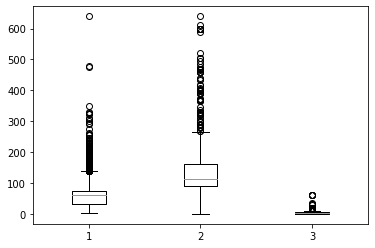

In [10]:
X1_column = df_train_fl["X1"]
X2_column = df_train_fl["X2"]
X3_column = df_train_fl["X3"]

train_fl_columns = [X1_column, X2_column, X3_column]

fig, ax = plt.subplots()
ax.boxplot(train_fl_columns)
plt.show()

In [11]:
# # Assigne des valeurs hors limites aux valeurs limites avec "pandas.DataFrame.clip"
# X1_column = X1_column.clip(lower=X1_column.quantile(.01), upper=X1_column.quantile(.99))
# # print(X1_column.shape)
# # X1_column.plot.box()
# X1_column = df_train_fl["X1"]

# X2_column = X2_column.clip(lower=X2_column.quantile(.01), upper=X2_column.quantile(.99))
# X2_column = df_train_fl["X2"]

<!-- #### "stats.zscore" ci-dessous calcule le Z-score de chaque valeur dans la colonne, par rapport à la moyenne de la colonne et à l’écart type.
#### Lors du calcul du Z-score, nous redimensionnons et centrons les données et recherchons les points de données qui sont trop éloignés de zéro. Si la valeur du score Z est supérieure ou inférieure à 3 ou -3 respectivement, ce point de données sera identifié comme des valeurs aberrantes.  -->

#### **1. 3. 3. Mise à l'échelle de dataframes numériques de données d'apprentissage et expérimentales**

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))

cols = ["X1", "X2", "X3", "X4"]
# transformation de données d'apprentissage
df_train_fl = pd.DataFrame(scaler.fit_transform(df_train_fl), columns = cols)
# transformation de données expérimentales
df_test_fl = pd.DataFrame(scaler.fit_transform(df_test_fl), columns = cols)

### **1. 4. Réduction de dimensionnalité de données d'apprentissage et expérimentales**

#### Tout en appliquant la réduction de dimensionnalité, nous ajustons d'abord le modèle à l'aide de données d'apprentissage, et ensuite nous pouvons utiliser pour transformer les données d'apprentissage et de validation. 

#### **1. 4. 1. SVD pour réduction de dimensionnalité des caractéristiques booléennes sparse** 

#### Séparation de la colonne de label de la base de données d'apprentissage booléenne:

In [13]:
label_train = df_train_bool.iloc[: , -1:] 
# label_train.shape # (1895, 1)
print(label_train.value_counts()) # 0: 1585, 1: 312

# drop the "outcome" column (binary label column):
df_train_bool = df_train_bool.iloc[: , :-1] 
df_train_bool.head()
df_train_bool.shape # (1895, 1556)

outcome
nonad.     1585
ad.         312
dtype: int64


(1897, 1554)

#### **1. 4. 2. Optimisation de parametre "n_components" pour TruncatedSVD**

référence : https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

In [14]:
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=df_train_bool.shape[1]-1)
X_tsvd = tsvd.fit(df_train_bool)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

# Calculating number of components required to pass threshold
def select_n_components(var_ratio, goal_var: float) -> int:

    total_variance = 0.0
    n_components = 0
    
    for explained_variance in var_ratio:
        # Add the explained variance to the total
        total_variance += explained_variance
        # Add one to the number of components
        n_components += 1
        
        if total_variance >= goal_var:
            break
            
    return n_components

select_n_components(tsvd_var_ratios, 0.95) # 273

273

#### **1. 4. 3. Application du codage SVD aux données d'apprentissage booléennes:**

In [15]:
SVD_model = TruncatedSVD(n_components=273).fit(df_train_bool)
print(df_train_bool.shape) # (1897, 734)

df_train_bool_reduced = pd.DataFrame(SVD_model.transform(df_train_bool)) # pd.DataFrame is used to retain as data frame object
print(df_train_bool_reduced.shape) # (1897, 290)

(1897, 1554)
(1897, 273)


In [16]:
# apply same transformation to df_test to boolean:
print(df_test_bool.shape) # (820, 1554)
df_test_bool_reduced = pd.DataFrame(SVD_model.transform(df_test_bool))
print(df_test_bool_reduced.shape)

(820, 1554)
(820, 273)


#### Rassembler des dataframes de données d'expérimentales : 

In [17]:
# # les index ne correspondent pas après le prétraitement, il faut tomber:
# df_test_bool_reduced.reset_index(drop=True, inplace=True)
# df_test_fl.reset_index(drop=True, inplace=True)

# # concaténation des jeux de données expérimentales booléens et numériques:
# x_test = pd.concat( [df_test_fl, df_test_bool_reduced], axis=1 )
# print((x_test.shape)) # (820, 27)
# x_test.head()

In [18]:
# les index ne correspondent pas après le prétraitement, il faut tomber:
df_test_bool.reset_index(drop=True, inplace=True)
df_test_fl.reset_index(drop=True, inplace=True)

# concaténation des jeux de données expérimentales booléens et numériques:
x_test = pd.concat( [df_test_fl, df_test_bool], axis=1 )
print((x_test.shape)) # (820, 27)
# x_test.head()

(820, 1558)


### **1. 5. Equilibrage des données largement en déséquilibre**

#### **1. 5. 1. Visualisation du ratio des classes**

Class 0: 1585
Class 1: 312
Proportion: 5.08 : 1


<AxesSubplot:title={'center':'Count (target)'}>

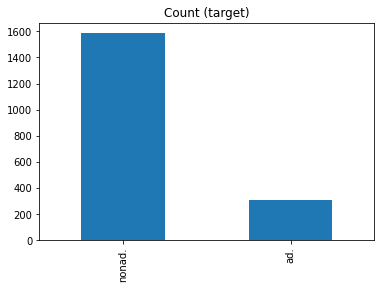

In [19]:
target_count = df_train.outcome.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

#### **1. 5. 2. Application de plusieurs méthodes de suréchantillonnage et comparaison avec la validation croisée**

#### Ajustement des méthodes de suréchantillonnage "SMOTE", "ADASYN" et "RandomOverSampler" pour comparer avec la validation croisée 10-fold: 

In [20]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(df_train_bool, label_train)

sm = SMOTE(random_state = 42)
x_sm, y_sm = sm.fit_resample(df_train_bool, label_train)

sm = ADASYN()
x_syn, y_syn = sm.fit_resample(df_train_bool, label_train)

In [21]:
# définir le pipeline 
# steps = [('svd', TruncatedSVD(n_components=272)), ('m', LogisticRegression())] 
# model = Pipeline(steps=steps)

model = LogisticRegression()
# évaluer le modèle 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

y_pred_ROS = cross_val_predict(model, x_over, y_over, cv=cv, n_jobs=-1) # 0.97 recall for nonad
print("classification report after RandomOverSampler:\n", classification_report(y_over, y_pred_ROS))

y_pred_sm = cross_val_predict(model, x_sm, y_sm, cv=cv, n_jobs=-1)
print("classification report after SMOTE:\n", classification_report(y_sm, y_pred_sm))

y_pred_syn = cross_val_predict(model, x_syn, y_syn, cv=cv, n_jobs=-1)
print("classification report after ADASYN:\n", classification_report(y_syn, y_pred_syn))

classification report after RandomOverSampler:
               precision    recall  f1-score   support

         ad.       0.97      0.95      0.96      1585
      nonad.       0.96      0.97      0.96      1585

    accuracy                           0.96      3170
   macro avg       0.96      0.96      0.96      3170
weighted avg       0.96      0.96      0.96      3170

classification report after SMOTE:
               precision    recall  f1-score   support

         ad.       0.91      0.94      0.92      1585
      nonad.       0.93      0.91      0.92      1585

    accuracy                           0.92      3170
   macro avg       0.92      0.92      0.92      3170
weighted avg       0.92      0.92      0.92      3170

classification report after ADASYN:
               precision    recall  f1-score   support

         ad.       0.86      0.98      0.92      1563
      nonad.       0.98      0.85      0.91      1585

    accuracy                           0.91      3148
   macr

#### RandomOverSampler donne les meilleurs f1-scores sur le jeu de données booléen, alors il sera appliquer:

In [22]:
oversample = RandomOverSampler(sampling_strategy='minority')
# suréchantillonnage de la trame de données d'apprentissage booléenne :
x_over_bool, y_over = oversample.fit_resample(df_train_bool, label_train) 
print((x_over_bool.shape), (y_over.shape))

(3170, 1554) (3170, 1)


#### Tailles des trames de données booléen avant suréchantillonnage: (1897, 290), et après suréchantillonnage: (3170, 290)

In [23]:
# suréchantillonnage de la trame de données d'apprentissage numérique:
x_over_fl, y_over = oversample.fit_resample(df_train_fl, label_train)
print((x_over_fl.shape), (y_over.shape))

(3170, 4) (3170, 1)


In [24]:
# concaténation de données d'apprentissage numérique et booléen:
x_over = pd.concat( [x_over_fl, x_over_bool], axis=1 )
print((x_over.shape))
x_over.head()

(3170, 1558)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
0,0.048589,0.358372,0.116138,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.090909,0.730829,0.129978,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.090909,0.730829,0.129978,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.089342,0.718310,0.129922,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.090909,0.364632,0.064977,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **2. Évaluation des modèles de classification avec validation croisée 10-fold**

#### À chaque itération, "cross_val_predict" générera un score métrique individuel pour ce lot. En fin de compte, il renverra k score pour chaque itération. 

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

model = LogisticRegression()
y_pred_logr = cross_val_predict(model, x_over, y_over, cv=cv, n_jobs=-1) 
print("classification report for logistic regression classifier:\n", classification_report(y_over, y_pred_logr))

classification report for logistic regression classifier:
               precision    recall  f1-score   support

         ad.       0.98      0.95      0.97      1585
      nonad.       0.96      0.98      0.97      1585

    accuracy                           0.97      3170
   macro avg       0.97      0.97      0.97      3170
weighted avg       0.97      0.97      0.97      3170



In [26]:
model = DecisionTreeClassifier()
y_pred_dt = cross_val_predict(model, x_over, y_over, cv=cv, n_jobs=-1) 
print("classification report for decision tree classifier:\n", classification_report(y_over, y_pred_dt))

classification report for decision tree classifier:
               precision    recall  f1-score   support

         ad.       0.93      0.97      0.95      1585
      nonad.       0.97      0.92      0.95      1585

    accuracy                           0.95      3170
   macro avg       0.95      0.95      0.95      3170
weighted avg       0.95      0.95      0.95      3170



#### Dans les matrices de confusion ci-dessus, les deux méthodes donnent le même score de *exactitude moyenne*. Étant donné que nos données ont un biais pour la classe minoritaire "nonad", nous devons comparer les valeurs de *rappel* et de *précision* pour être sûr que cette classe est correctement classée. Pour la classe non publicitaire, la valeur *rappel* renvoie 0,93 avec le classificateur *d'arbre de décision* et 0,98 avec le classificateur de *régression logistique*. Par conséquent, le classificateur de régression logistique surpasse le classificateur d'arbre de décision pour cet ensemble de données. 

## **3. Prédictions basées sur des modèles**

### **3. 1. Ajuster un modèle de régression logistique**

In [27]:
print(x_over.shape)
print(y_over.shape)

(3170, 1558)
(3170, 1)


In [28]:
logreg_model = LogisticRegression()
logreg_model.fit(x_over, y_over)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression()

#### Prediction avec les données expérimentales :

In [29]:
y_pred_logreg = logreg_model.predict(x_test) # numpy.ndarray

In [30]:
# # enregistre dans un fichier CSV
# savetxt('y_pred_logreg.csv', y_pred, delimiter=',', fmt=('%s'))

### **3. 2. Ajuster un modèle de réseau neuronal profond**

In [31]:
# transformer la colonne de label des chaînes en entiers https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html 
lb = preprocessing.LabelBinarizer()
y_over = lb.fit_transform(y_over) # 'numpy.ndarray' object 

In [32]:
# Diviser les données d'apprentissage pour obtenir l’ensemble de données de validation :
x_train, x_valid, y_train, y_valid = train_test_split(x_over, y_over, test_size=0.33, shuffle= True)

In [33]:
# créer un modèle de perceptron multicouche avec nombre de couches 7:
def create_model():
    model = Sequential()
    model.add(Dropout(.4))
    model.add(Dense(128, input_dim = x_train.shape[1], activation = 'sigmoid'))
    model.add(Dropout(.4))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(.3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(.1))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(2, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

# compile model:
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])
    # La perte d’entropie croisée binaire est utilisée pour l'applications de classification binaire (0 ou 1). 
    return model

In [34]:
# évaluer le modèle avec un ensemble de données standardisé 
keras_model = KerasClassifier(build_fn = create_model, verbose=1) 

# ajustement du modèle keras sur l'ensemble de données de validation
history = keras_model.fit(x_train, y_train, 
                    epochs=400, 
                    batch_size=50, 
                    validation_data=(x_valid, y_valid), 
                    shuffle=True)

Epoch 1/400
43/43 [==============================] - 2s 24ms/step - loss: 0.6945 - recall: 0.5004 - precision: 0.4767 - accuracy: 0.0000e+00 - val_loss: 0.6749 - val_recall: 0.9387 - val_precision: 0.8673 - val_accuracy: 0.0000e+00
Epoch 2/400
43/43 [==============================] - 0s 5ms/step - loss: 0.6763 - recall: 0.5055 - precision: 0.5951 - accuracy: 0.0000e+00 - val_loss: 0.5641 - val_recall: 0.6245 - val_precision: 0.9132 - val_accuracy: 0.0000e+00
Epoch 3/400
43/43 [==============================] - 0s 6ms/step - loss: 0.5880 - recall: 0.7026 - precision: 0.7485 - accuracy: 0.0000e+00 - val_loss: 0.4445 - val_recall: 0.9789 - val_precision: 0.8474 - val_accuracy: 0.0000e+00
Epoch 4/400
43/43 [==============================] - 0s 5ms/step - loss: 0.4820 - recall: 0.8770 - precision: 0.8024 - accuracy: 0.0000e+00 - val_loss: 0.4331 - val_recall: 0.9923 - val_precision: 0.7945 - val_accuracy: 0.0000e+00
Epoch 5/400
43/43 [==============================] - 0s 5ms/step - loss: 0.

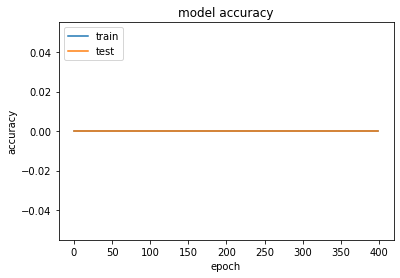

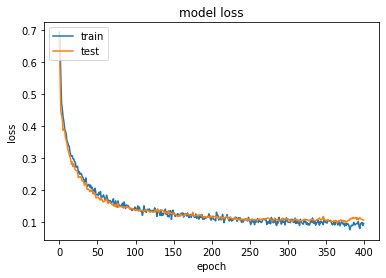

In [35]:
# résumer l'histoire pour précision 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# résumer l'histoire pour fonction de perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred = keras_model.predict(x_test) # numpy.ndarray
# print(y_pred)

26/26 [==============================] - 0s 1ms/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [37]:
# inverse transformer la prédiction en valeur de chaîne
y_pred = lb.inverse_transform(y_pred, threshold=None)
# print(y_pred)

# enregistre dans un fichier CSV
savetxt('y_pred_keras.csv', y_pred, delimiter=',', fmt=('%s'))